In [ ]:
import umap
import numpy as np
import plotly.express as px
import pandas as pd

dataset_name = 'CODEX_cHL_CIM_MASK_VP_LONG'
n_components = 2

# =========================
# Load data
# =========================
train_file = np.load(f'/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/MCA/z_RUNS/{dataset_name}/train_results.npz')
val_file = np.load(f'/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/MCA/z_RUNS/{dataset_name}/val_results.npz')

train_features = train_file['features']
val_features = val_file['features']

train_labels_str = train_file['labels_str']
val_labels_str = val_file['labels_str']

# Load predictions (numerical indices)
train_label_preds = train_file['top1_pred_num']
val_label_preds = val_file['top1_pred_num']

# Convert numerical predictions to class names
num2class = {i: name for i, name in enumerate(list(val_file['classes']))}
train_preds_str = np.array([num2class[i] for i in train_label_preds])
val_preds_str = np.array([num2class[i] for i in val_label_preds])

# =========================
# Subsample
# =========================
N = 10_000
M = 5_000

def get_random_idxs(MAX, N):
    return np.random.permutation(MAX)[:N]

train_idxs = get_random_idxs(len(train_features), N)
val_idxs = get_random_idxs(len(val_features), M)

train_features = train_features[train_idxs]
val_features = val_features[val_idxs]

train_labels_str = train_labels_str[train_idxs]
val_labels_str = val_labels_str[val_idxs]
train_preds_str = train_preds_str[train_idxs]
val_preds_str = val_preds_str[val_idxs]

all_features = np.vstack([train_features, val_features])
all_labels = np.concatenate([train_labels_str, val_labels_str])
all_preds = np.concatenate([train_preds_str, val_preds_str])
all_split = np.array(["Train"] * len(train_idxs) + ["Val"] * len(val_idxs))

# Calculate correct/incorrect predictions
correct_mask = all_labels == all_preds
correct_status = np.where(correct_mask, "Correct", "Incorrect")

print("Total samples:", len(all_features))
print(f"Correct predictions: {correct_mask.sum()} / {len(correct_mask)} ({100*correct_mask.mean():.1f}%)")

# =========================
# UMAP embedding
# =========================
reducer = umap.UMAP(
    n_neighbors=5,
    min_dist=0.01,
    spread=1.0,
    n_components=n_components,
    metric="euclidean",
    n_jobs=2
)

embedding = reducer.fit_transform(all_features)

# =========================
# DataFrame
# =========================
df_data = {
    "x": embedding[:, 0],
    "y": embedding[:, 1],
    "label": all_labels,
    "predicted": all_preds,
    "correct": correct_status,
    "is_correct": correct_mask.astype(int),
    "split": all_split
}

if n_components == 3:
    df_data["z"] = embedding[:, 2]

df = pd.DataFrame(df_data)

# =========================
# PLOTTING FUNCTIONS
# =========================

def plot_umap(color_by='label', show_correct_only=None, opacity_incorrect=0.3):
    """
    Plot UMAP with various coloring options.
    
    Parameters:
    -----------
    color_by : str
        'label' - color by true labels
        'predicted' - color by predicted labels  
        'correct' - color by correct/incorrect predictions
    show_correct_only : bool or None
        None - show all points
        True - show only correct predictions
        False - show only incorrect predictions
    opacity_incorrect : float
        Opacity for incorrect predictions when color_by='label' or 'predicted'
    """
    
    # Filter data if requested
    plot_df = df.copy()
    if show_correct_only is True:
        plot_df = plot_df[plot_df['correct'] == 'Correct']
        title_suffix = " (Correct Only)"
    elif show_correct_only is False:
        plot_df = plot_df[plot_df['correct'] == 'Incorrect']
        title_suffix = " (Incorrect Only)"
    else:
        title_suffix = ""
    
    # Determine coloring
    if color_by == 'label':
        color_col = 'label'
        color_map_dict = {lab: px.colors.qualitative.Alphabet[i % len(px.colors.qualitative.Alphabet)] 
                         for i, lab in enumerate(np.unique(all_labels))}
        hover_data = ['label', 'predicted', 'correct', 'split']
        
    elif color_by == 'predicted':
        color_col = 'predicted'
        color_map_dict = {lab: px.colors.qualitative.Alphabet[i % len(px.colors.qualitative.Alphabet)] 
                         for i, lab in enumerate(np.unique(all_preds))}
        hover_data = ['label', 'predicted', 'correct', 'split']
        
    elif color_by == 'correct':
        color_col = 'correct'
        color_map_dict = {'Correct': '#2ecc71', 'Incorrect': '#e74c3c'}  # Green/Red
        hover_data = ['label', 'predicted', 'correct', 'split']
    
    # Create opacity array to de-emphasize incorrect predictions
    if color_by in ['label', 'predicted'] and show_correct_only is None:
        opacity_values = np.where(plot_df['correct'] == 'Correct', 0.85, opacity_incorrect)
    else:
        opacity_values = 0.85
    
    # Build plot
    if n_components == 3:
        fig = px.scatter_3d(
            plot_df,
            x="x",
            y="y",
            z="z",
            color=color_col,
            symbol="split",
            symbol_map={"Train": "circle", "Val": "cross"},
            color_discrete_map=color_map_dict,
            hover_data=hover_data,
            title=f"{n_components}D UMAP - Colored by {color_by.capitalize()}{title_suffix}",
            width=1200,
            height=900,
            opacity=1.0  # We handle opacity via marker properties
        )
        scene_kwargs = dict(
            xaxis_title="UMAP-1",
            yaxis_title="UMAP-2",
            zaxis_title="UMAP-3"
        )
    else:
        fig = px.scatter(
            plot_df,
            x="x",
            y="y",
            color=color_col,
            symbol="split",
            symbol_map={"Train": "circle", "Val": "cross"},
            color_discrete_map=color_map_dict,
            hover_data=hover_data,
            title=f"{n_components}D UMAP - Colored by {color_by.capitalize()}{title_suffix}",
            width=1200,
            height=900,
            opacity=1.0
        )
        scene_kwargs = dict(
            xaxis_title="UMAP-1",
            yaxis_title="UMAP-2"
        )
    
    # Apply custom opacity per point (correct vs incorrect)
    if color_by in ['label', 'predicted'] and show_correct_only is None:
        for trace in fig.data:
            # Get indices for this trace
            mask = plot_df[color_col] == trace.name if color_col in plot_df.columns else np.ones(len(plot_df), dtype=bool)
            trace.opacity = 0.85  # Base opacity
            trace.marker.size = 4
            # Note: Plotly doesn't support per-point opacity in scatter easily, 
            # so we use marker size to indicate correctness instead
            # trace.marker.size = np.where(plot_df.loc[mask, 'correct'] == 'Correct', 10, 5)
    
    # Marker styling
    fig.update_traces(
        marker=dict(
            line=dict(width=0.0, color="black")
        )
    )
    
    if n_components == 3:
        fig.update_layout(legend_title=color_by.capitalize(), scene=scene_kwargs)
    else:
        fig.update_layout(legend_title=color_by.capitalize(), **scene_kwargs)
    
    fig.show()
    return fig

# =========================
# USAGE EXAMPLES
# =========================

# 1. Color by TRUE labels (default, all points same opacity)
plot_umap(color_by='label')

# 2. Color by PREDICTED labels
plot_umap(color_by='predicted')

# 3. Color by TRUE labels but de-emphasize incorrect predictions (smaller points)
plot_umap(color_by='label', opacity_incorrect=0.2)

# 4. Color by whether prediction is CORRECT (green=correct, red=wrong)
plot_umap(color_by='correct')

# 5. Show ONLY correct predictions (colored by true label)
plot_umap(color_by='label', show_correct_only=True)

# 6. Show ONLY incorrect predictions (colored by true label) - good for error analysis
plot_umap(color_by='label', show_correct_only=False)

# 7. Show ONLY incorrect predictions colored by PREDICTED label
plot_umap(color_by='predicted', show_correct_only=False)

In [ ]:
import einops
activations = einops.rearrange(all_features, 'N (C F) -> N C F', C=int(all_features.shape[1]/32)).mean(axis=-1)

In [ ]:
from mmengine import Config
from mmengine.registry import init_default_scope, DATASETS
from mmengine.runner import Runner
import torch

# 1. Load config
cfg_path = f'/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/MCA/z_RUNS/{dataset_name}/{dataset_name}.py'
cfg = Config.fromfile(cfg_path)
dataset = DATASETS.build(cfg['train_dataset'])

runner = Runner.from_cfg(cfg);

In [ ]:
for marker in dataset.marker2idx.keys():
    df[marker] = activations[:, dataset.marker2idx[marker]]

In [ ]:
dataset.marker2idx

In [ ]:
for marker in list(dataset.marker2idx.keys()):
    if marker != 'Granzyme B':
        continue
    
    fig = px.scatter_3d(
        df,
        x="x",
        y="y",
        z="z",
        color=marker,
        symbol="split",
        symbol_map={
            "train": "circle",
            "val": "cross"
        },
        color_discrete_map=color_map,
        hover_data=["label", "split"],
        title=marker,
        width=1200,
        height=900
    )

    # Marker styling
    fig.update_traces(
        marker=dict(
            size=2,
            opacity=0.85,
            line=dict(width=0, color="black")
        )
    )

    fig.update_layout(
        legend_title="Cell Type",
        scene=dict(
            xaxis_title="UMAP-1",
            yaxis_title="UMAP-2",
            zaxis_title="UMAP-3"
        )
    )

    fig.show()
    
    # Wait for user input before showing next figure
    input("Press Enter to continue to next marker...")

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

tmp = df[df.label == 'B']

# Assuming your dataframe is called 'tmp'
# First, let's identify the marker columns (excluding metadata columns)
metadata_cols = ['x', 'y', 'z', 'label', 'split']
marker_cols = [col for col in tmp.columns if col not in metadata_cols]

print(f"Found {len(marker_cols)} markers to analyze: {marker_cols[:5]}...")

# Split data
train_data = tmp[tmp['split'] == 'Train']
test_data = tmp[tmp['split'] == 'Val']  # or 'Test' depending on your naming

results = []

for marker in marker_cols:
    
    train_values = train_data[marker].values
    test_values = test_data[marker].values
    
    results.append({
        'marker': marker,
        'train_mean': np.mean(train_values),
        'test_mean': np.mean(test_values),
        'train_std': np.std(train_values),
        'test_std': np.std(test_values)
    })

# Convert to DataFrame and rank
results_df = pd.DataFrame(results)

In [ ]:
results_df

In [ ]:
import torch
from torch import nn


In [7]:
from MCA.src.models_attention import MCIANet
model = MCIANet(40, 20, 32, 4, 2, 3, 1, 2, 0.05, 0.35, 'gaussian')
model.spatial_focus.context_conv._skip_init

True

In [8]:
model.spatial_focus.context_conv.weight

Parameter containing:
tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
        

In [9]:
import torch 

model(torch.randn(2, 40, 20, 20))[0].shape

torch.Size([2, 1280])

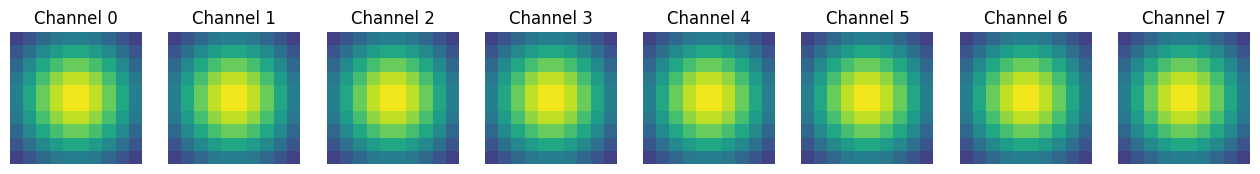

In [10]:
import matplotlib.pyplot as plt

# Pick first batch sample
masks = model.last_spatial_masks[0]  # [C, 1, H, W]
C = masks.shape[0]

fig, axes = plt.subplots(1, min(C, 8), figsize=(16, 2))
for i in range(min(C, 8)):
    axes[i].imshow(masks[i, 0].detach().cpu(), cmap='viridis', vmin=0, vmax=1)
    axes[i].set_title(f'Channel {i}')
    axes[i].axis('off')
plt.show()


torch.Size([40, 40])


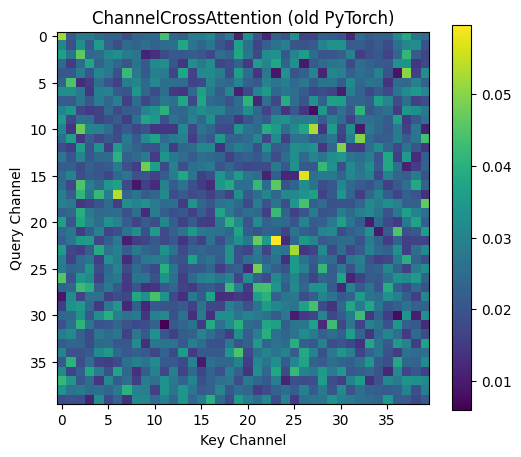

In [11]:
# Pick first sample
attn = model.attn1.last_attn[0]
print(attn.shape)# [C, C]
plt.figure(figsize=(6, 5))
plt.imshow(attn.cpu(), cmap='viridis')
plt.colorbar()
plt.title('ChannelCrossAttention (old PyTorch)')
plt.xlabel('Key Channel')
plt.ylabel('Query Channel')
plt.show()
